# Feature Extraction: SIFT

## Setup

In [ ]:
#import libraries
import webdataset as wds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
sns.set_style('darkgrid')

In [3]:
#paths
root = '.'
data_folder = f'{root}/feature_data/corrected'
feature_data_folder = f'{root}/feature_data/sift' 

## Load Data

In [29]:
def load_data(path_to_data: str):
    """
    load 2D images and their labels

    returns: 
    images (array): array of images as np arrays
    labels (array): array of labels
    """
    #create lists to store images and labels
    images = []
    labels = []

    #load webdataset
    data = (wds.WebDataset(f'{path_to_data}', shardshuffle=True)
        .decode("pil")
        .to_tuple("jpg", "json")
        .map(lambda row: (np.array(row[0]), row[1]['label'])))

    #append dataset to lists
    for image, label in data:
        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    data.close()

    return images, labels

In [30]:
train_images, train_labels = load_data(f'file:{data_folder}/train-000000.tar')
val_images, val_labels = load_data(f'file:{data_folder}/val-000000.tar')
test_images, test_labels = load_data(f'file:{data_folder}/test-000000.tar')

In [31]:
print("Shape of images:", train_images.shape)
print("Shape of labels:", train_labels.shape)

Shape of images: (8449, 227, 227, 3)
Shape of labels: (8449,)


## Testing Downsizing

In [82]:
def downsize(img_dataset):
    downsized_dataset = []
    for i in range(len(img_dataset)):
        downsized_dataset.append(cv2.pyrDown(img_dataset[i]))
    return np.array(downsized_dataset)

In [83]:
train_images = downsize(train_images)
val_images = downsize(val_images)
test_images = downsize(test_images)

In [84]:
print("Shape of images:", train_images.shape)
print("Shape of labels:", train_labels.shape)

Shape of images: (8252, 114, 114, 3)
Shape of labels: (8252,)


## View Class Samples

In [9]:
def plot_class_samples(images: list, labels: list):
    fig, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(20,3))

    for i, (label, image) in enumerate(zip(labels, images)):
        ax = axs[i]
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

    fig.suptitle('One Image For Each Class')
    plt.show()

def load_class_samples(images: list, labels: list) -> tuple:
    label_names = ['crater', 'dark dune', 'slope streak', 'bright dune', 'impact ejecta', 'swiss cheese', 'spider']
    unique_labels = np.unique(labels)

    sample_images = []
    sample_labels = []

    for value in unique_labels:
        label = label_names[value - 1]
        index = int(np.where(train_labels==value)[0][0])

        sample_labels.append(label)
        sample_images.append(images[index])
    
    return sample_images, sample_labels

In [10]:
sample_imgs, sample_lbls = load_class_samples(train_images, train_labels)

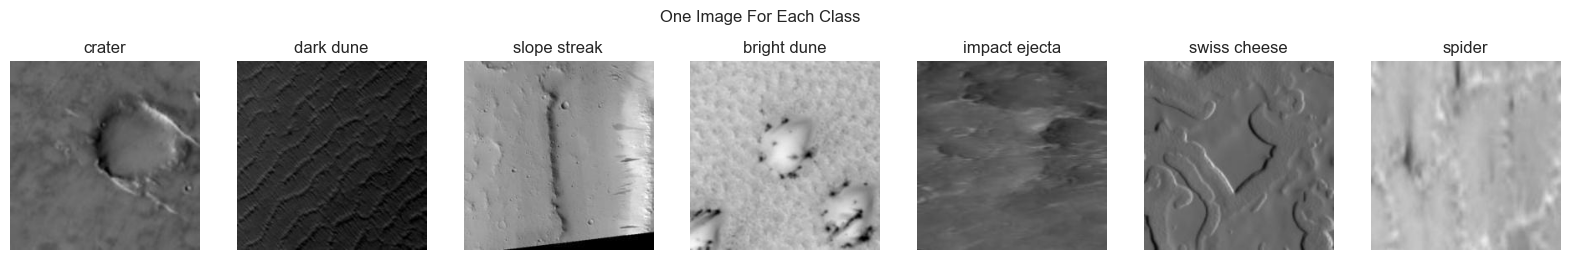

In [11]:
plot_class_samples(sample_imgs, sample_lbls)

## Feature Extraction: SIFT

In [67]:
def get_sift_feature(imgs: list) -> tuple:
    nfeats = 10 #25
    sift = cv2.SIFT_create(nfeatures=nfeats)
    sift_kp = []
    sift_ar = []

    for img in imgs:
        kp, des = sift.detectAndCompute(img, None)

        if len(kp) > nfeats:
            kp = kp[:nfeats]
            des = des[:nfeats]

        if des is None:
            des = np.zeros((nfeats, 128))
        elif len(kp) < nfeats:
            des = np.pad(des, ((0, nfeats - len(kp)), (0, 0)), mode='constant')

        sift_kp.append(kp)
        sift_ar.append(des.ravel())

    return sift_kp, np.array(sift_ar)

def get_sift_descriptors(imgs: list) -> tuple:
    sift = cv2.SIFT_create(nfeatures=500)
    sift_ar = []
    nones = []

    for img in imgs:
        _, des = sift.detectAndCompute(img, None)
        if des is None:
            des = np.zeros((1, 128))
            nones.append(img)
        sift_ar.append(des)

    return sift_ar, nones

def plot_keypoint_samples(sample_kp: list, sample_imgs: list, sample_labels: list):
    fig, axs = plt.subplots(nrows=1, ncols=len(sample_kp), figsize=(20,3))

    samples = zip(sample_labels, sample_imgs, sample_kp)

    for i, (label, img, kp) in enumerate(samples):
        ax = axs[i]

        #ax.hist(sample.ravel(), 256, [0,256])
        sift_image = cv2.drawKeypoints(
            img, kp, 0, (0, 0, 255), #blue color circles 
            flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

        ax.imshow(sift_image)
        ax.set_title(label)
        ax.axis('off')

    fig.suptitle('SIFT Features per Class')
    plt.show()

### View Sift Sample

In [13]:
sample_kp, sample_sift = get_sift_feature(sample_imgs)

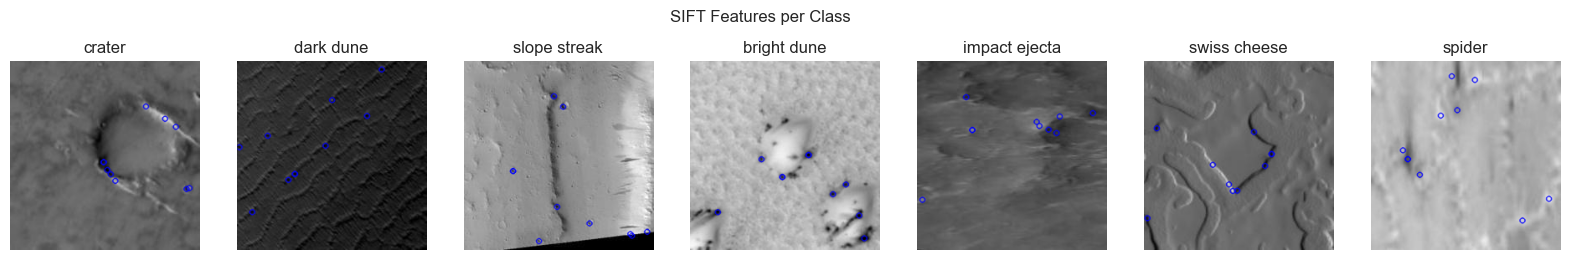

In [14]:
plot_keypoint_samples(sample_kp, sample_imgs, sample_lbls)

In [75]:
train_sift, train_zeros = get_sift_descriptors(train_images)
val_sift, val_zeros = get_sift_descriptors(val_images)
test_sift, test_zeros = get_sift_descriptors(test_images)

<Axes: ylabel='Count'>

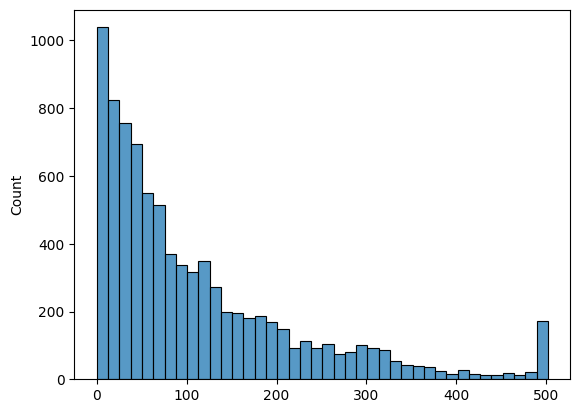

In [33]:
lens = np.array([len(desc) for desc in train_sift])
sns.histplot(x=lens)

In [ ]:
def pad_sift_helper(arr: list, cutoff: int) -> list:
    remaining = cutoff - len(arr)

    if remaining <= 0:
        return arr[:cutoff]

    additional = np.zeros((remaining, 128))
    if len(arr) == 0:
        return additional

    return np.concatenate([arr, additional])

def pad_sift(arr: list, cutoff: int) -> list:
    return np.array([pad_sift_helper(sift, cutoff) for sift in arr])

In [35]:
np.mean(lens), np.min(lens), np.max(lens)

(111.55639720677003, 0, 502)

In [36]:
len(train_zeros), len(val_zeros), len(test_zeros)

(182, 100, 10)

In [71]:
train_sift.shape

(942722, 128)

In [72]:
kmeans = KMeans(n_clusters=1000)
kmeans.fit(np.vstack(train_sift))

KMeans(n_clusters=1000)

In [76]:
vocabulary = kmeans.cluster_centers_

In [77]:
len(vocabulary)

1000

In [84]:
def compute_hist_helper(sift, vocab) -> list:
    hist = np.zeros(len(vocab))
    for desc in sift:
        idx = np.argmin(np.linalg.norm(vocab - desc, axis=1))
        hist[idx] += 1

    return hist

def compute_hist(sift, vocab) -> list:
    return [compute_hist_helper(desc, vocab) for desc in sift]

def build_hist(sift: list, kmeans) -> list:
    preds = kmeans.predict(np.array(sift, dtype=np.double))
    hist = np.zeros(len(kmeans.cluster_centers_))

    for pred in preds:
        hist[pred] += 1

    return hist

def build_hists(sift: list, kmeans) -> list:
    return [build_hist(desc, kmeans) for desc in sift]

In [79]:
train_sift[0].dtype

dtype('float32')

In [86]:
train_bow = build_hists(train_sift, kmeans)
val_bow = build_hists(val_sift, kmeans)
test_bow = build_hists(test_sift, kmeans)

In [89]:
train_bow = np.array(train_bow)
val_bow = np.array(val_bow)
test_bow = np.array(test_bow)

In [92]:
tsne = TSNE(n_components=2)
reduced_vocab = tsne.fit_transform(train_bow)

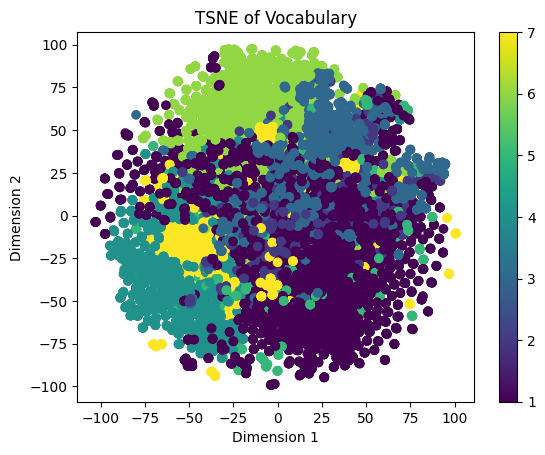

In [93]:
plt.scatter(reduced_vocab[:, 0], reduced_vocab[:, 1], c=train_labels, cmap='viridis', marker='o')
plt.title('TSNE of Vocabulary')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

In [5]:
train_sift.shape

(8449, 64256)

In [94]:
np.save(f'{feature_data_folder}/train_bow.npy', train_bow)
np.save(f'{feature_data_folder}/val_bow.npy', val_bow)
np.save(f'{feature_data_folder}/test_bow.npy', test_bow)

## PCA

In [95]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_bow)

In [96]:
pca = PCA()
pca.fit(X_scaled)

PCA()

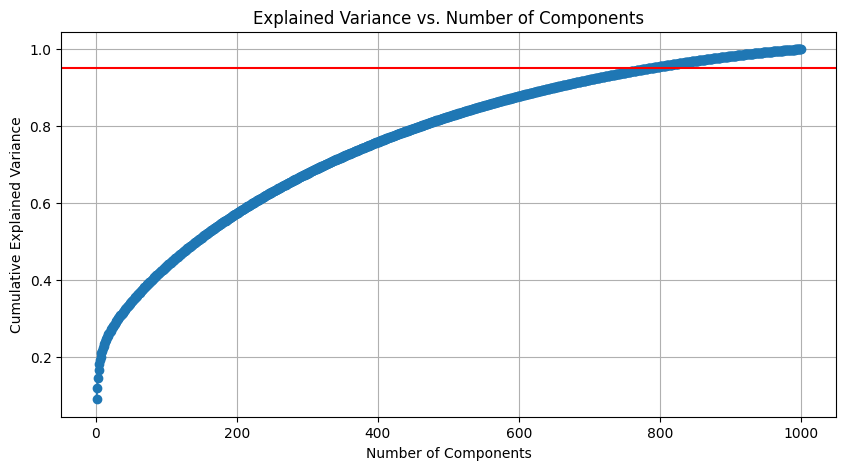

In [97]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
# draw a line at 90% of explained variance
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

## PCA down to 1500, $\approx 95\%$

In [96]:
pca = PCA(n_components=700) #1500 before
pca.fit(X_scaled)

PCA(n_components=700)

In [97]:
train_sift = pca.transform(scaler.transform(train_sift))
val_sift = pca.transform(scaler.transform(val_sift))
test_sift = pca.transform(scaler.transform(test_sift))

In [30]:
np.save(f'{feature_data_folder}/train_sift.npy', train_sift)
np.save(f'{feature_data_folder}/val_sift.npy', val_sift)
np.save(f'{feature_data_folder}/test_sift.npy', test_sift)

### View Clusters

In [74]:
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(X_scaled)

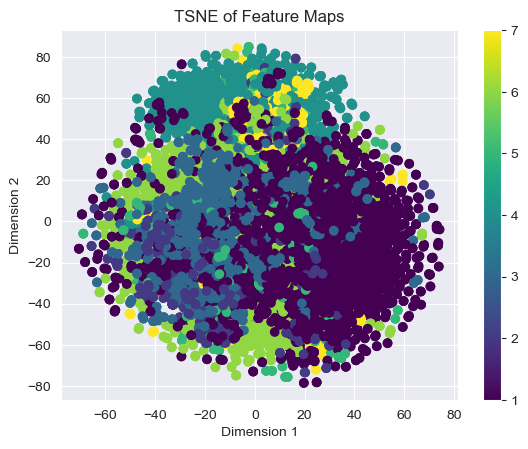

In [76]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=train_labels, cmap='viridis', marker='o')
plt.title('TSNE of Feature Maps')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

### Predictive Power

In [110]:
clf = LogisticRegression(max_iter = 70, class_weight='balanced').fit(train_bow, train_labels)

In [108]:
from sklearn import svm

In [113]:
clf = svm.SVC(class_weight='balanced').fit(train_bow, train_labels)

In [114]:
clf.score(train_bow, train_labels)

0.9250798911113741

In [115]:
clf.score(val_bow, val_labels)

0.6930166607585962

Heavily overfit this does mean though that there is a lot of informative data in the features however, we may need to cut the space down even further

In [29]:
preds = clf.predict(train_sift)
corr = preds == train_labels

In [30]:
df = pd.DataFrame({'correct': corr, 'label': train_labels})

In [31]:
df.head()

,correct,label
0,True,7
1,True,7
2,True,7
3,True,7
4,True,7


Text(0, 0.5, 'Count')

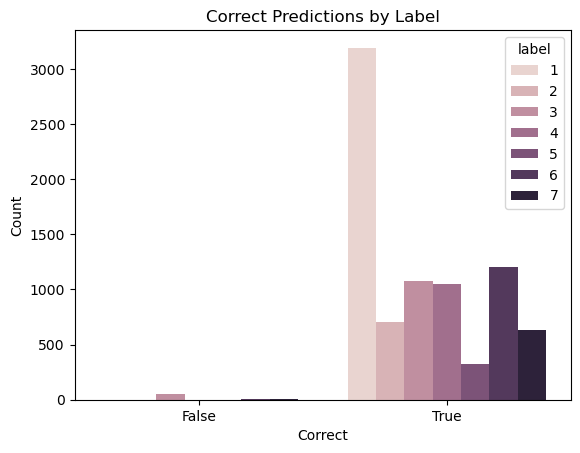

In [32]:
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')